In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [25]:
x_train = pd.read_csv('data/train.csv', engine='pyarrow').drop(columns=['SAMPLE_ID', 'ID'])
x_val = pd.read_csv('data/test.csv', engine='pyarrow').drop(columns=['SAMPLE_ID', 'ID'])
x_train.ATA = pd.to_datetime(x_train.ATA, format='%Y-%m-%d %H:%M:%S')
x_train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 04:03:00,30.0,28,73100,20.0,10.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 02:55:00,30.0,15,37900,20.0,10.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 06:43:00,50.0,7,115000,20.0,10.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06:00,10.0,33,1490,10.0,0.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57:00,30.0,10,27600,10.0,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23:00,40.0,13,93200,20.0,10.0,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,JP,QYY1,Tanker,0.000000,2022-04-29 02:58:00,10.0,9,1280,0.0,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 07:58:00,30.0,6,25000,20.0,10.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07:00,10.0,8,2400,10.0,0.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


# Categorical Columns

In [3]:
for cat_col in x_train.columns[x_train.dtypes=='object']:
    num_of_values = x_train[cat_col].value_counts().shape[0]
    print(f'{cat_col:18s} has {num_of_values:5d} kinds of values')

ARI_CO             has    25 kinds of values
ARI_PO             has   103 kinds of values
SHIP_TYPE_CATEGORY has     4 kinds of values
SHIPMANAGER        has  6511 kinds of values
FLAG               has   123 kinds of values


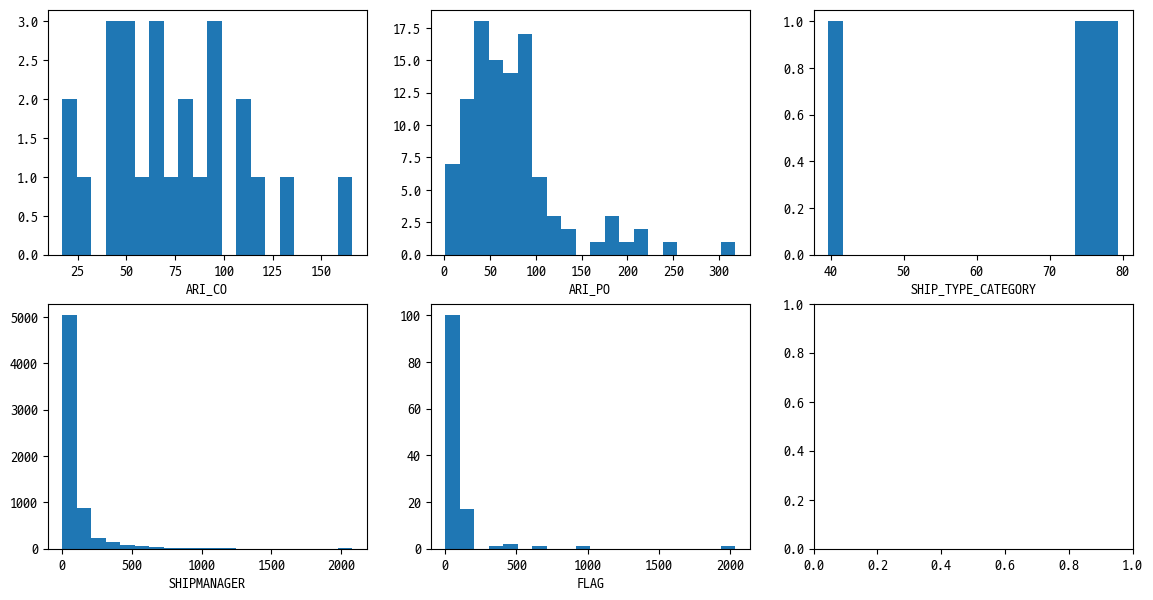

In [4]:
fig, axes = plt.subplots(2, 3, dpi=100, figsize=(14, 7))
for ax, cat_col in zip(axes.ravel(), x_train.columns[x_train.dtypes=='object']):
    temp = x_train.groupby(cat_col)['CI_HOUR'].mean().values
    ax.hist(temp, bins=20)
    ax.set_xlabel(cat_col)

## Modification

In [5]:
x_train['ARI'] = x_train.loc[:, 'ARI_CO'] + x_train.loc[:, 'ARI_PO']
x_val['ARI'] = x_val.loc[:, 'ARI_CO'] + x_val.loc[:, 'ARI_PO']

x_train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
x_val.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

In [6]:
temp = x_train.SHIP_TYPE_CATEGORY.value_counts().sort_index()
ship_type_mapper = dict(zip(temp.index, range(len(temp))))
x_train['SHIP_TYPE_CATEGORY'] = x_train['SHIP_TYPE_CATEGORY'].map(ship_type_mapper)
x_val['SHIP_TYPE_CATEGORY'] = x_val['SHIP_TYPE_CATEGORY'].map(ship_type_mapper)

# Numerical Columns

## `NaN` checking

In [7]:
x_train.loc[:, x_train.columns[x_train.dtypes==float]].isnull().sum(axis=0)

DIST                    0
BREADTH                 1
DEPTH                   1
DRAUGHT                 1
LENGTH                  1
U_WIND             153486
V_WIND             153486
AIR_TEMPERATURE    154365
BN                 153486
DUBAI                   0
BRENT                   0
WTI                     0
BDI_ADJ                 0
PORT_SIZE               0
CI_HOUR                 0
dtype: int64

In [8]:
for col in ['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH']:
    print(x_train.index[x_train[col].isnull()].item())

23856
23856
23856
23856


In [9]:
x_train.drop(index=23856, inplace=True)
x_train.loc[:, x_train.columns[(x_train.dtypes==np.int64) | (x_train.dtypes==np.float64)]].isnull().sum(axis=0)

SHIP_TYPE_CATEGORY         0
DIST                       0
BREADTH                    0
BUILT                      0
DEADWEIGHT                 0
DEPTH                      0
DRAUGHT                    0
GT                         0
LENGTH                     0
U_WIND                153486
V_WIND                153486
AIR_TEMPERATURE       154365
BN                    153486
ATA_LT                     0
DUBAI                      0
BRENT                      0
WTI                        0
BDI_ADJ                    0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

+ `U_WIND`, `V_WIND`, `BN` have same indices of `NaN`.
+ `AIR_TEMPERATURE` has dfferent indices of `NaN`.

In [10]:
nan_indices = x_train.index[x_train.U_WIND.isnull()]
for col in ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']:
    temp = x_train.index[x_train[col].isnull()]
    if len(nan_indices) == len(temp):
        print(f'{col:15s}', set(nan_indices) == set(temp))

U_WIND          True
V_WIND          True
BN              True


In [11]:
count = 0
for nan_index in x_train.index[x_train.AIR_TEMPERATURE.isnull()]:
    if nan_index not in nan_indices:
        count += 1

print(count)

879


+ $879 = 154365 - 153486$.
+ `153,486` rows includes `NaN` for column `U_WIND`, `V_WIND`, `BN`, `AIR_TEMPERATURE`. Especially, `AIR_TEMPERATURE` has `879` more `NaN` values.

## Correlation

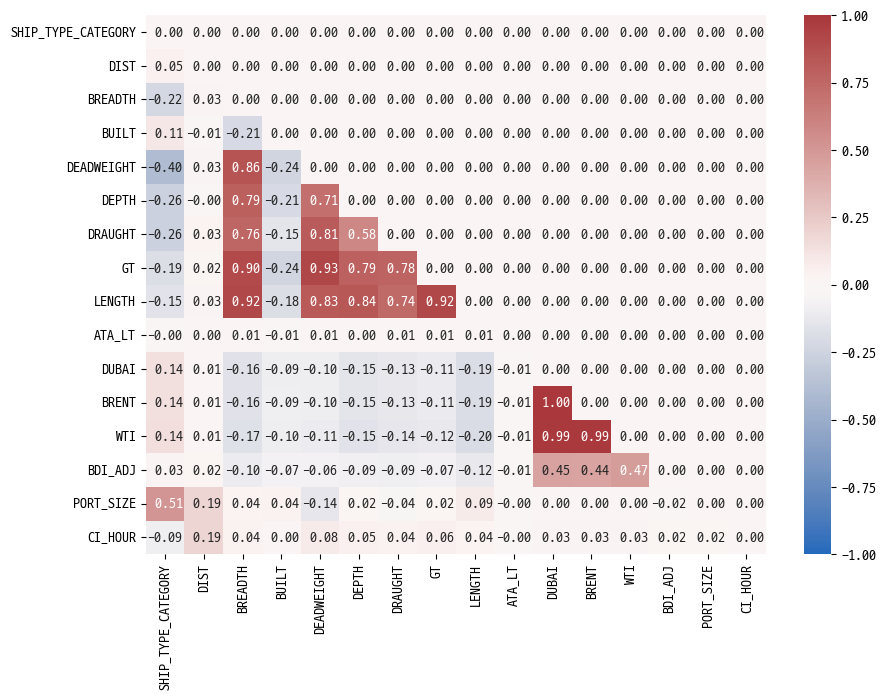

In [12]:
num_nonan = list(x_train.columns[(x_train.dtypes==np.int64) | (x_train.dtypes==np.float64)])
num_nonan = [num_col for num_col in num_nonan if num_col not in ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']]
corr_matrix = np.corrcoef(x_train.loc[:, num_nonan].values.T)
corr_matrix = np.tril(corr_matrix)
np.fill_diagonal(corr_matrix, 0)

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(10, 7))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap=cmap, fmt='5.2f', annot=True, )
ax.set_xticklabels(num_nonan, rotation=90)
ax.set_yticklabels(num_nonan, rotation=0)
None

In [13]:
temp = x_train.loc[:, ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'CI_HOUR']]
temp.drop(index=temp.index[temp['AIR_TEMPERATURE'].isnull()], inplace=True)
corr = np.corrcoef(temp.values.T)
corr = np.tril(corr)
corr

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.09413136,  1.        ,  0.        ,  0.        ,  0.        ],
       [-0.11251666,  0.18658012,  1.        ,  0.        ,  0.        ],
       [-0.09549086, -0.18284197, -0.00314134,  1.        ,  0.        ],
       [-0.01213918,  0.0176509 ,  0.0355209 , -0.01707728,  1.        ]])

## Scatter Plot

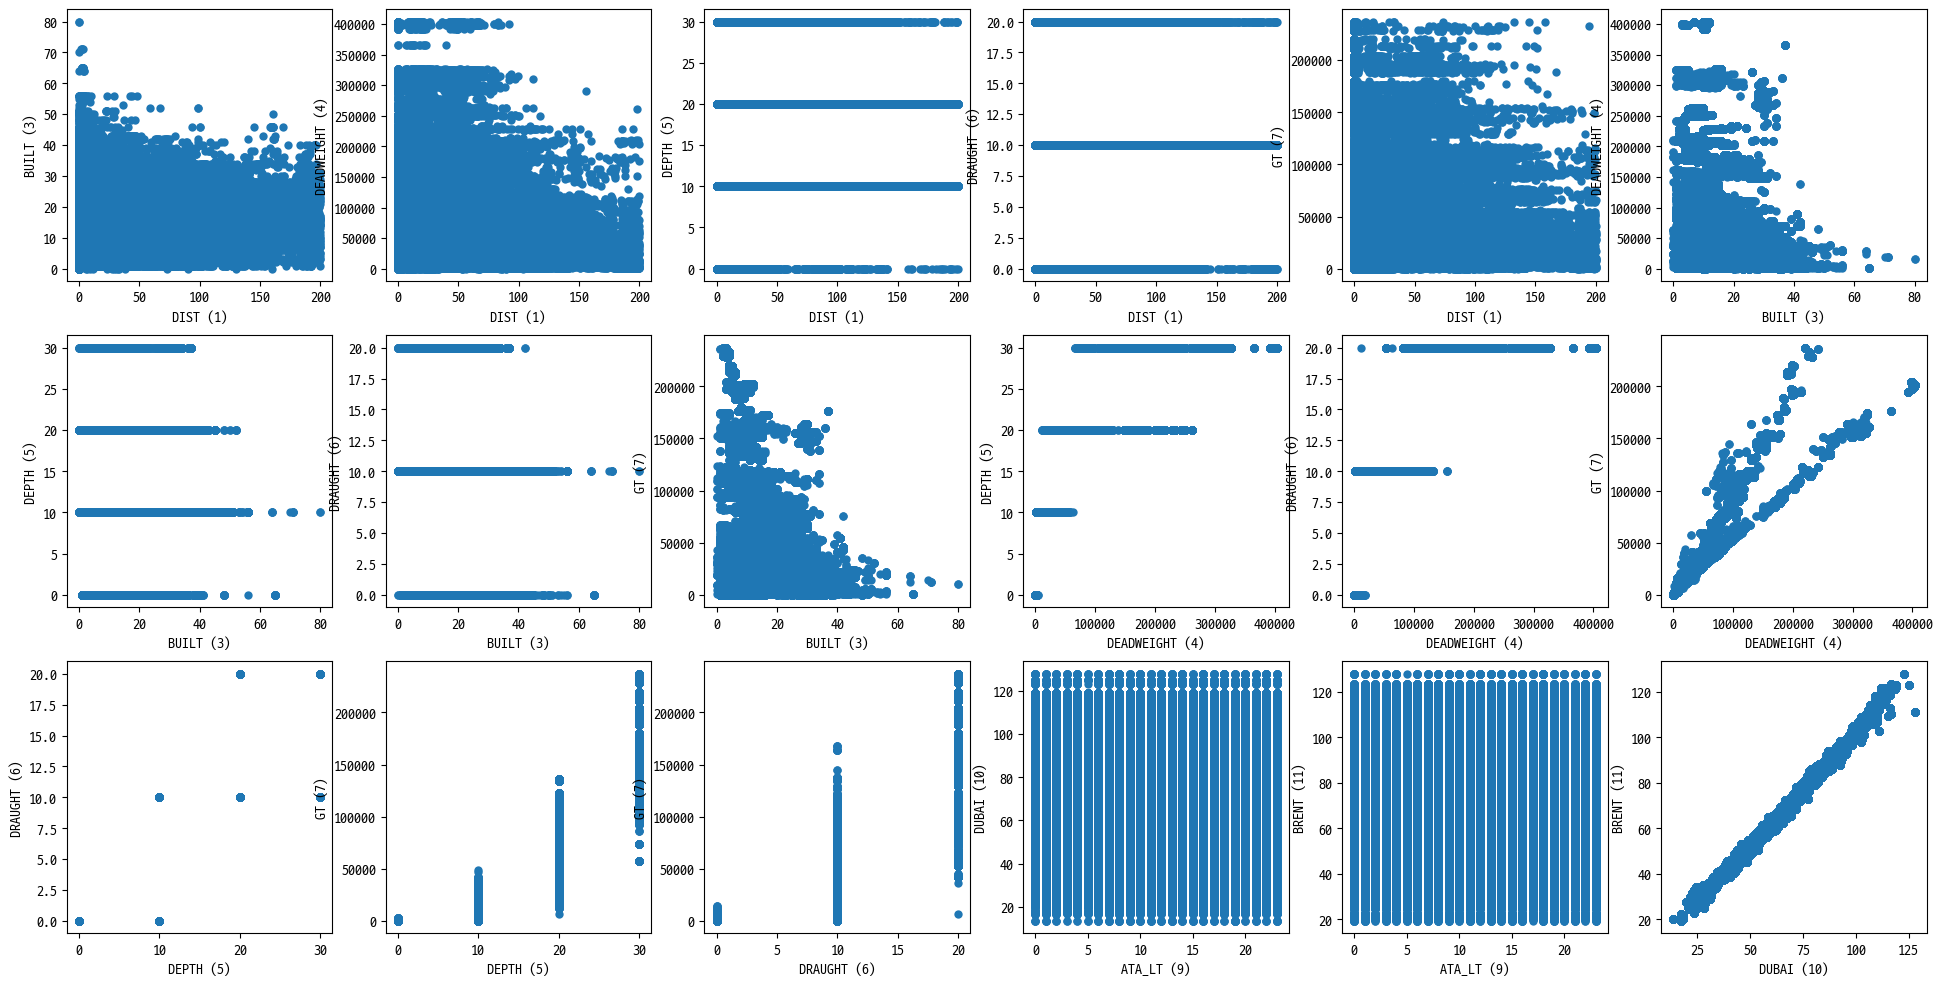

In [14]:
from itertools import combinations

fig, axes = plt.subplots(3, 6, dpi=100, figsize=(24, 12))
axis_indices = list(combinations([1, 3, 4, 5, 6, 7], 2)) + list(combinations([9, 10, 11], 2))

for (x_index, y_index), ax in zip(axis_indices, axes.ravel()):
    sns.scatterplot(data=x_train, x=num_nonan[x_index], y=num_nonan[y_index], linewidth=0, ax=ax)
    ax.set_xlabel(f'{num_nonan[x_index]} ({x_index})')
    ax.set_ylabel(f'{num_nonan[y_index]} ({y_index})')

### Deletion of Identical columns & Addition of Clusters

In [15]:
drop_columns = ['BRENT', 'WTI', 'LENGTH']

<Axes: xlabel='DEADWEIGHT', ylabel='GT'>

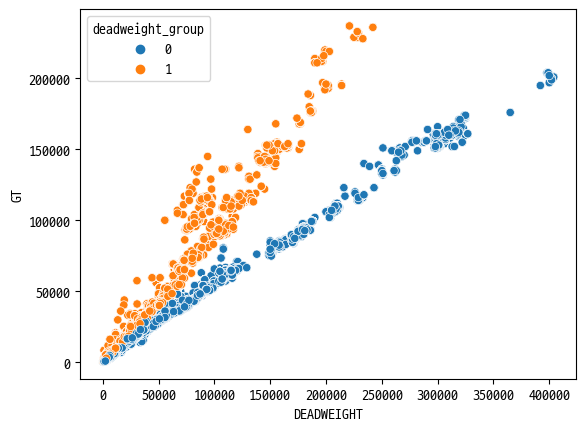

In [16]:
clusters = []; clusters_append = clusters.append
for (dw, gt) in x_train.loc[:, ['DEADWEIGHT', 'GT']].values:
    if abs(gt-dw) < abs(gt-0.5*dw):
        clusters_append(1)
    else:
        clusters_append(0)

x_train['deadweight_group'] = np.array(clusters)
sns.scatterplot(data=x_train, x='DEADWEIGHT', y='GT', hue='deadweight_group')

<Axes: xlabel='DEADWEIGHT', ylabel='GT'>

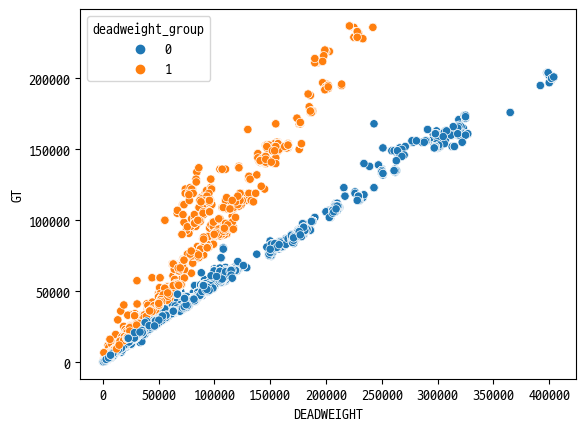

In [17]:
clusters = []; clusters_append = clusters.append
for (dw, gt) in x_val.loc[:, ['DEADWEIGHT', 'GT']].values:
    if abs(gt-dw) < abs(gt-0.5*dw):
        clusters_append(1)
    else:
        clusters_append(0)

x_val['deadweight_group'] = np.array(clusters)
sns.scatterplot(data=x_val, x='DEADWEIGHT', y='GT', hue='deadweight_group')

In [18]:
drop_columns.append('GT')

## Outlier in `WTI`
+ `WTI` price went below zero for about 6 weeks

In [19]:
sum(x_train['WTI'] < 0)

121

In [20]:
x_train.loc[x_train.WTI<0, 'ATA'].sort_values()

133937   2020-03-06 06:17:00
62325    2020-03-26 15:49:00
230225   2020-04-08 05:42:00
192746   2020-04-09 07:08:00
279756   2020-04-09 13:21:00
                 ...        
156280   2020-04-20 20:17:00
160360   2020-04-20 21:24:00
327211   2020-04-20 21:57:00
332417   2020-04-20 23:43:00
77748    2020-04-20 23:46:00
Name: ATA, Length: 121, dtype: datetime64[ns]

### Deletion of `Negative Oil Price` timing

In [21]:
x_train.drop(index=x_train.index[x_train.WTI<0], inplace=True)

### Deletion of Identical Columns

In [22]:
x_train.drop(columns=drop_columns, inplace=True)
x_val.drop(columns=drop_columns, inplace=True)

# Save

In [23]:
x_train.to_csv('data/train_preprocessed.csv', encoding='UTF-8', index=False)
x_val.to_csv('data/test_preprocessed.csv', encoding='UTF-8', index=False)